# Bayesian parameter estimation: temporal discounting example

Benjamin T. Vincent, [@inferenceLab](https://twitter.com/inferencelab)

In comparison to the previous linear regression example, here we attempt to move on from _describing_ the data to _explaining_ the data with a cognitive model.

## Delay discounting
Delay discounting is related to the classic marshmallow experiment. In delay discounting experiments, people make repeated choices between a smaller sooner reward or a larger later reward. By setting up your questions to cover a range of immediate rewards, delayed rewards, and delay extent, we can find points at which participants switch from preferring smaller sooner to larger later rewards. By doing this we can charachterise the preferences of individuals along a spectrum of more present to more future focussed. We can get more of an idea about this with the hyperbolic discounting from the [interactive web app](https://inferencelab.shinyapps.io/hyperbolic_discounting_demo/) I made.

To be more concrete, participants would answer questions such as, would you prefer?
- £80 now, or £85 in 157 days
- £34 now, or £50 in 30 days
- and so on...

We will look at exactly this kind of data, along with responses. Our task will be to infer parameters of the hyperbolic discounting model. The most important will be the $\log(k)$, the log discount rate. 

In this notebook, we will look at a simple hyperbolic discounting model of delay discounting and we will use Bayesian inference to estimate the parameters so as to score a participant's discount rate. Interested readers are pointed to Vincent (2015) which outlines Bayesian hierarchical modelling of delay discounting data. We will use [Julia](https://julialang.org) as the programming language, and [Turing.jl](https://turing.ml) (Ge, Xu, & Ghahramani, 2018) as the Bayesian inference package.

## Setup
Importing packages for the first time can take a little while in Julia.

In [1]:
using Turing, StatsPlots

## Load data
Load in real data we got from one participant in the Kirby delay discounting task. So we have 27 items in this test. The variables are:
- `A` the smaller but soon reward amount
- `DA` the delay until the smaller amount, in days. Here all the smaller rewards are immediate.
- `B` the larger delayed reward amount
- `DB` the delay until the larger amount
- `R` the response, where $R=0$ means chose option A, and $R=1$ means chose option B.

In [2]:
A = [80, 34, 25, 11, 49, 41, 34, 31, 19, 22, 55, 28, 47, 14, 54, 69, 54, 25, 27, 40, 54, 15, 33, 24, 78, 67, 20]
DA = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
B = [85, 50, 60, 30, 60, 75, 35, 85, 25, 25, 75, 30, 50, 25, 80, 85, 55, 30, 50, 55, 60, 35, 80, 35, 80, 75, 55]
DB = [157, 30, 14, 7, 89, 20, 186, 7, 53, 136, 61, 179, 160, 19, 30, 91, 117, 80, 21, 62, 111, 13, 14, 29, 162, 119, 7]
R = [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1];

We can visualise our data in order to get some intuition about the problem. The positioning of the points is dicated by the Kirby questionnaire, and the colour represents the choice made. Our task is to use the hyperbolic discounting model in order to predict the responses that this observer made.

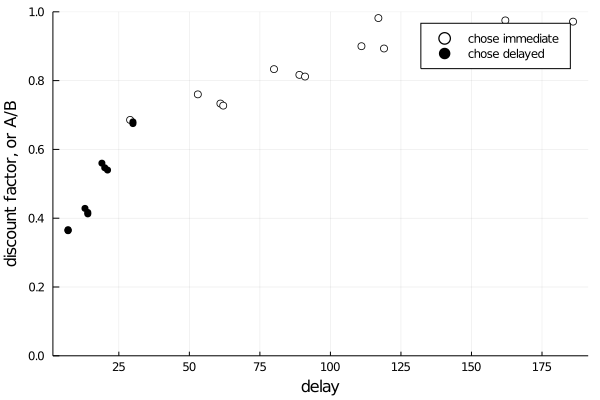

In [3]:
function plot_data(A, DA, B, DB, R)
    I = R.==0
    scatter(DB[I], A[I] ./ B[I], color=:white, label="chose immediate")
    D = R.==1
    scatter!(DB[D], A[D] ./ B[D], color=:black, label="chose delayed")
    plot!(xlabel="delay", ylabel="discount factor, or A/B", ylim=(0, 1))
end

plot_data(A, DA, B, DB, R)

## Define our model
First we define the hyperbolic discount function which provides a discount fraction for a given logk parameter value and a particular delay.

In [4]:
@model function hyperbolic_model(A, DA, B, DB, R)
    
    # priors
    logk ~ Normal(-4, 1)
    α ~ Gamma(1,1)
    ϵ ~ Beta(1+1, 1+10)
    
    # discounting model
    VA = A .* hyperbolic_discounting.(logk, DA)
    VB = B .* hyperbolic_discounting.(logk, DB)
    x = VB .- VA  # decision variable
    θ = psychometric_function.(x, α, ϵ)
    
    # likelihood
    @. R ~ Bernoulli(θ)
end;

Define the hyperbolic discount function as $\frac{1}{1+k\cdot \text{delay}}$.

In [5]:
hyperbolic_discounting(logk, delay) = 1 / (1 + exp(logk) * delay);

Responses are modelled as stochastic, so we define a psychometric function which calculates 'probability of choosing the delayed reward' based upon the decision variable $x$, a comparison acuity parameter $\alpha$ and a lapse rate $\epsilon$.

In [6]:
psychometric_function(x, α, ϵ) = ϵ + (1.0 - 2.0 * ϵ) * logistic_function(x*α)

logistic_function(x) = 1.0 / (1.0 + exp(-x));

We can visualise this psychometric function with example parameters

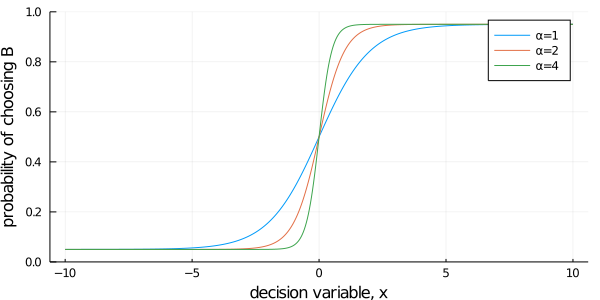

In [7]:
xi = LinRange(-10, 10, 500)
plot(size=(600, 300))
plot!(xi, psychometric_function.(xi, 1, 0.05), label="α=1")
plot!(xi, psychometric_function.(xi, 2, 0.05), label="α=2")
plot!(xi, psychometric_function.(xi, 4, 0.05), label="α=4")
plot!(xlabel="decision variable, x", ylabel="probability of choosing B", ylim=(0, 1))

The code below defines our Bayesian hyperbolic discounting model. This is quite nice to do using the Turing.jl package because the amount of code we had to write is 

## Check the priors

We can visually check out prior beliefs over the variables, so that we can check we have done things right and to make sure we can justify our prior beliefs to a reviewer.

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


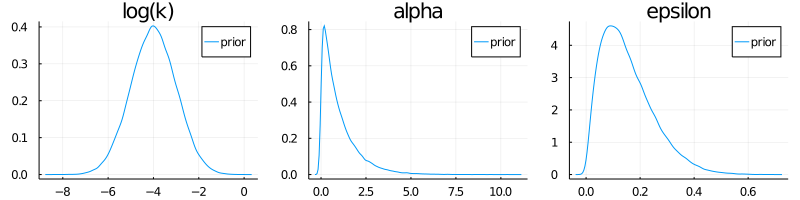

In [8]:
# sample from the prior
prior = sample(hyperbolic_model(A, DA, B, DB, R), Prior(), 50_000);

plot(layout=(1, 3), size=(800, 200))
density!(vec(Array(prior["logk"])), subplot=1, label="prior", title="log(k)")
density!(vec(Array(prior["α"])), subplot=2, label="prior", title="alpha")
density!(vec(Array(prior["ϵ"])), subplot=3, label="prior", title="epsilon")

Now we'll make a plot to see how our priors (over $\log(k)$) influence our range of plausible predictions.

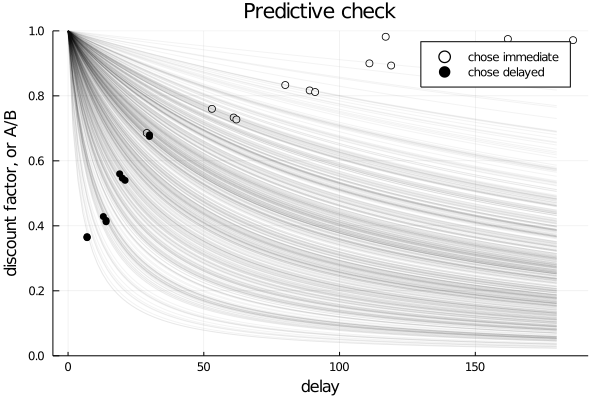

In [9]:
function plot_predictive(chains; N=100, plotmean=true)
    logk_mean = mean(vec(Array(chains["logk"])))
    subssample = sample(chains, N)
    logk = vec(Array(subssample["logk"]))
    xi = LinRange(0, 180, 100)
    for i in 1:N
        plot!(xi, hyperbolic_discounting.(logk[i], xi), label=false, color=:black, alpha=0.05)
    end
    if plotmean
        plot!(xi, hyperbolic_discounting.(logk_mean, xi), lw=3, color=:red, label=false)
    end
    plot!(title="Predictive check")  # to make the plot appear
end

plot()
plot_data(A, DA, B, DB, R)
plot_predictive(prior; N=500, plotmean=false)

In this case, we might decide that we need a broader prior over discount rates to capture the fact that more people might be either very low or very high discounters.

## Sample from the posterior

The line below conducts Bayesian inference with the model and data specified, `hyperbolic_model(A, DA, B, DB, R)`. We use the No-U-Turn sampler (e.g. Hoffman & Gelman, 2014) and ask for 2000 samples from 4 independent chains. We will get some read information and warning output, but in this case there is nothing to be concerned about.

<div class="alert alert-block alert-info">
<b>Tip:</b> Julia functions can be slow the first time you run them. So for bigger models or datasets you might run the sample function with very few samples just to warm things up, then run it again with the full amount of samples you want.</div>

In [10]:
posterior = sample(hyperbolic_model(A, DA, B, DB, R), NUTS(1000, .95), MCMCThreads(), 2000, 4)

┌ Info: Found initial step size
│   ϵ = 0.6000000000000001
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/XLLTf/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 3.2
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/XLLTf/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/XLLTf/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/XLLTf/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/benjamv/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/benjamv/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ W

Chains MCMC chain (2000×15×4 Array{Float64,3}):

Iterations        = 1:2000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 2000
parameters        = logk, α, ϵ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

        logk   -4.3786    0.2984     0.0033    0.0058   2582.8215    1.0024
           α    1.0451    0.8429     0.0094    0.0136   3622.1645    1.0005
           ϵ    0.0592    0.0391     0.0004    0.0006   4966.5654    1.0003

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        logk   -4.9939   -4.5559   -4.3447   -4.2026   -3.7503
     

## Check posterior samples are good
We can check our estimated posterior distribution over samples with a trace plot. The left column shows the set of samples produced by the MCMC sampling algorithm. The right hand column shows the distribition of samples. With MCMC, we represent our distribution of beliefs by the density of samples.

We also have 4 different colours here, representing 4 independent MCMC chains. We do this to check that each chain has converged and there is agreement between each chain. We get a quantitative evaluation of this with the `rhat` measure in the summary table above, obtained from sampling. If `rhat` values are greater than 1.01 (around abouts) then we probably have disagreement between the chains and we need to think more.

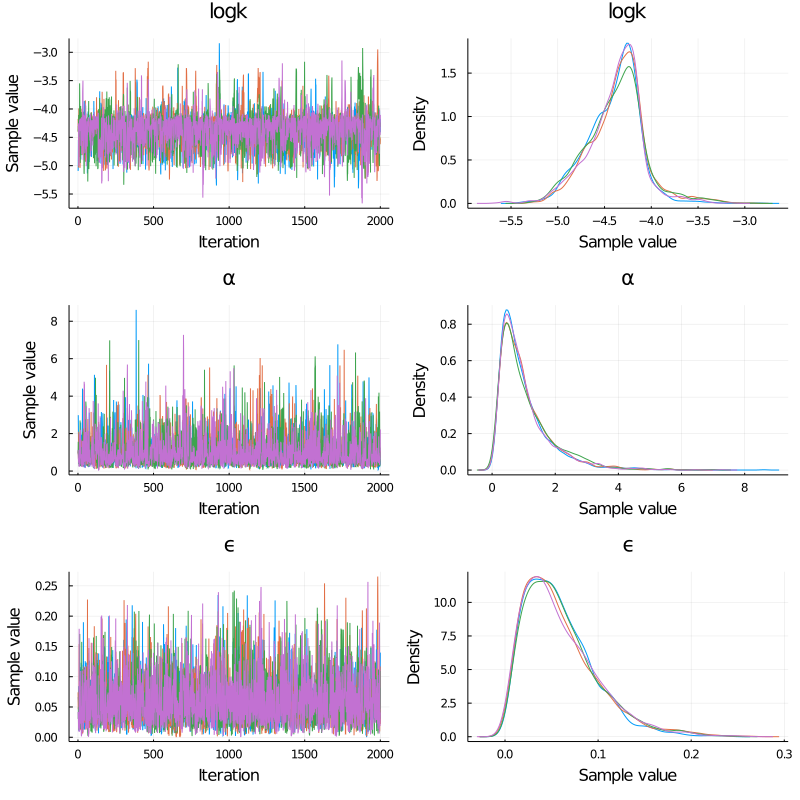

In [11]:
plot(posterior, size=(800, 800))

And we can see how the data has updated our beliefs (represented by samples from the posterior distribution) as compared to our prior beliefs.

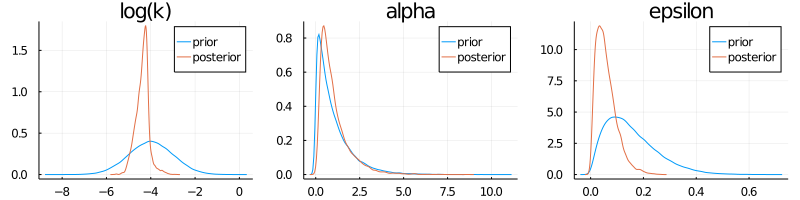

In [12]:
plot(layout=(1, 3), size=(800, 200))
density!(vec(Array(prior["logk"])), subplot=1, label="prior", title="log(k)")
density!(vec(Array(prior["α"])), subplot=2, label="prior", title="alpha")
density!(vec(Array(prior["ϵ"])), subplot=3, label="prior", title="epsilon")
density!(vec(Array(posterior["logk"])), subplot=1, label="posterior")
density!(vec(Array(posterior["α"])), subplot=2, label="posterior")
density!(vec(Array(posterior["ϵ"])), subplot=3, label="posterior")

## Visualise the fits
We can also do a sanity check that the model produces a good fit to the data by doing posterior predictive checks. This is an informal way of visually confirming that the model 'makes sense' and does a good or a bad job of accounting for the data.

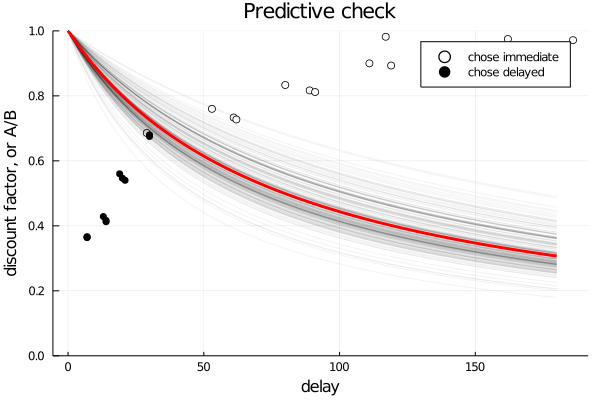

In [13]:
plot()
plot_data(A, DA, B, DB, R)
plot_predictive(posterior; N=200)

This is a good way of visualising data from delay discounting experiments (when the sooner delay is immediate). The data points are shown by the circles: empty circles represent discounting questions where the participant chose the immediate option (choice A), filled circles where they chose the delayed option (choice B).

The red curve represents the hyperbolic discount function corresponding to our best guess (posterior mean) of  $\log(k)$. The thin grey lines corresponds to many samples from our posterior distribution, and therefore visually demonstrates our uncertainty in the estimate of the discount rate.

We can see that our estimates are good here because the discount function does a good job of separating the immediate from the delayed choices.

**Question:** Why is our posterior over the discount rate not more sharply peaked than it is? Hint: think about how we are modelling response stochasticity.

## Recap
It's important to realise that the code here required to do the job is actually very minimal. All you really need is:

```julia
    using Turing, StatsPlots
    
    # load data
    A = [80, 34, 25, 11, 49, 41, 34, 31, 19, 22, 55, 28, 47, 14, 54, 69, 54, 25, 27, 40, 54, 15, 33, 24, 78, 67, 20]
    DA = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    B = [85, 50, 60, 30, 60, 75, 35, 85, 25, 25, 75, 30, 50, 25, 80, 85, 55, 30, 50, 55, 60, 35, 80, 35, 80, 75, 55]
    DB = [157, 30, 14, 7, 89, 20, 186, 7, 53, 136, 61, 179, 160, 19, 30, 91, 117, 80, 21, 62, 111, 13, 14, 29, 162, 119, 7]
    R = [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1];

    hyperbolic_discounting(logk, delay) = 1 / (1 + exp(logk) * delay)
    psychometric_function(x, α, ϵ) = ϵ + (1.0 - 2.0 * ϵ) * logistic_function(x*α)
    logistic_function(x) = 1.0 / (1.0 + exp(-x))

    @model function hyperbolic_model(A, DA, B, DB, R)
        logk ~ Normal(-4, 1)
        α ~ Gamma(1,1)
        ϵ ~ Beta(1+1, 1+10)
        VB = B .* hyperbolic_discounting.(logk, DB)
        x = VB .- A
        θ = psychometric_function.(x, α, ϵ)
        @. R ~ Bernoulli(θ)
    end

    prior = sample(hyperbolic_model(A, DA, B, DB, R), Prior(), 50_000)
    posterior = sample(hyperbolic_model(A, DA, B, DB, R), NUTS(1000, .95), MCMCThreads(), 2000, 4)
```

## References
- Ge, H., Xu, K., & Ghahramani, Z. (2018). Turing: A language for flexible probabilistic inference. In International Conference on Artificial Intelligence and Statistics (pp. 1682-1690).
- Hoffman, Matthew D., and Andrew Gelman. The No-U-Turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo. J. Mach. Learn. Res. 15.1 (2014): 1593-1623.
- Vincent, B. T. (2015). Hierarchical Bayesian estimation and hypothesis testing for delay discounting tasks. Behavior research methods, 48(4), 1608-1620.